# Bert原理
## 概论
> 由于现有模型都使用单向语言模型(`GPT`), 无法充分了解单词所在的上下文结构(类似于单向 `RNN` 网络的缺点)

`Bert`引入了 `Masked Language Model` 和 `Next sentence prediction` 两个预训练任务:
1. `Masked Language Model`: 随机屏蔽 15% `token`, 之后让模型根据上下文来预测被 `Mask` 的 `token`
2. `Next sentence prediction`任务预训练针对文本对, 预测句子间的关系(从 `token-level` 提升到 `sentence-level`)

## Bert模型
`Bert`: 分为 `pre-training` 和 `fine-tuning`两个阶段
- `pre-traning`: `Bert`在无标记的数据上进行无监督学习
- `fine-tuning`: `Bert`利用预训练的参数初始化模型, 并且利用下游任务标记好的数据进行有监督学习, 并且对于所有参数进行微调
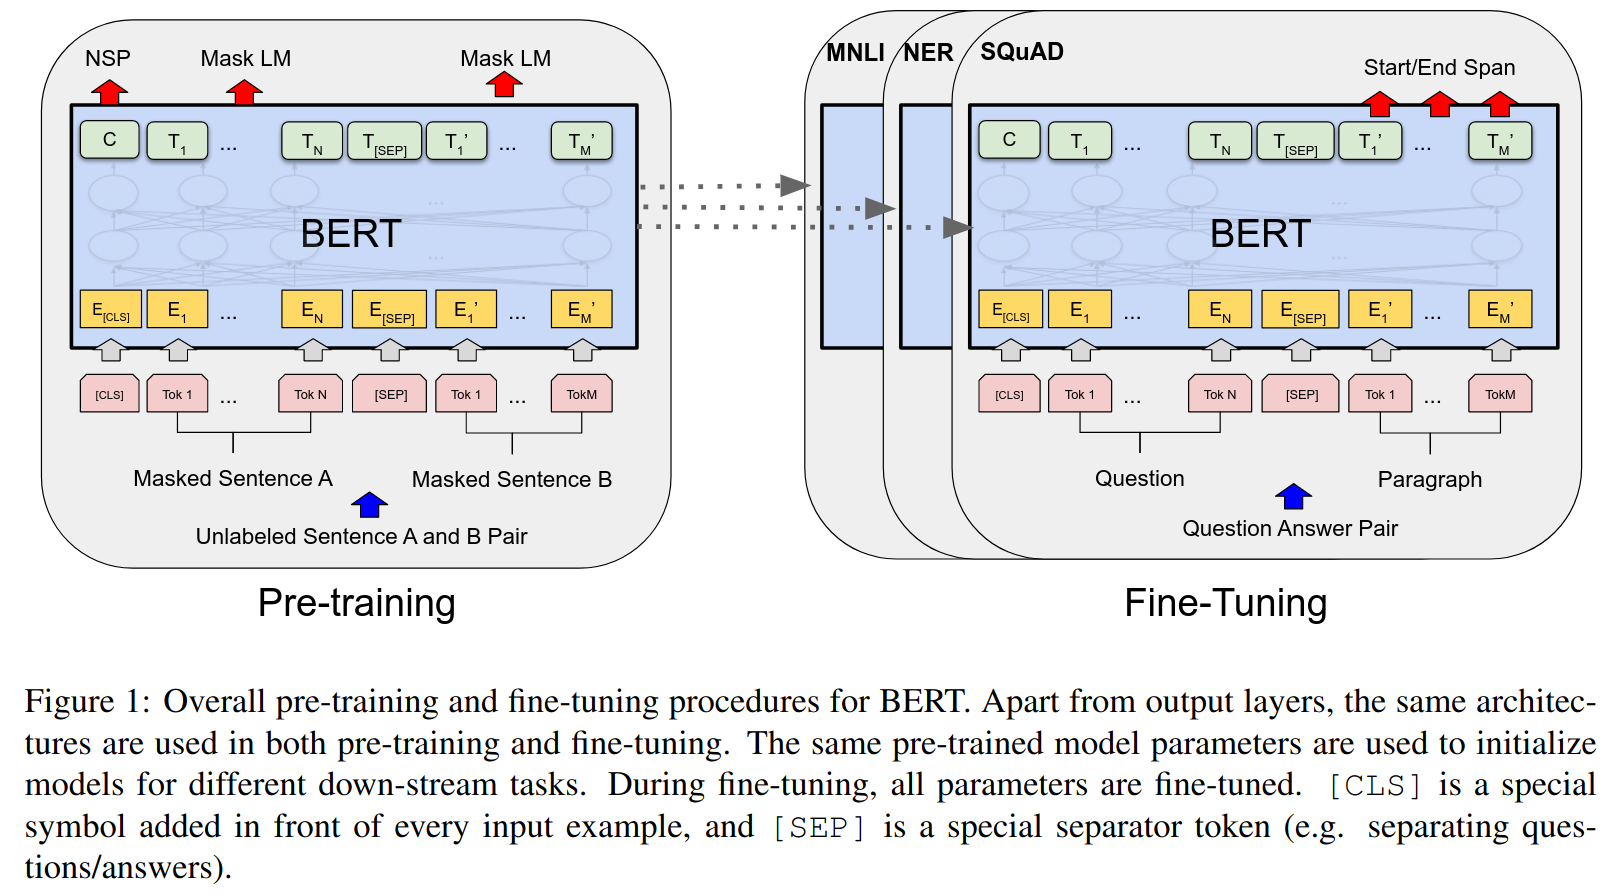
后面 `fine-tuning` 不同的层表示不同的下游任务都使用相同的模型结构
### 模型架构
`BERT`有多层双向的`Transformer Encoder`结构组成, 区分与 `GPT` 的单向 `Transformer Decoder` 架构:
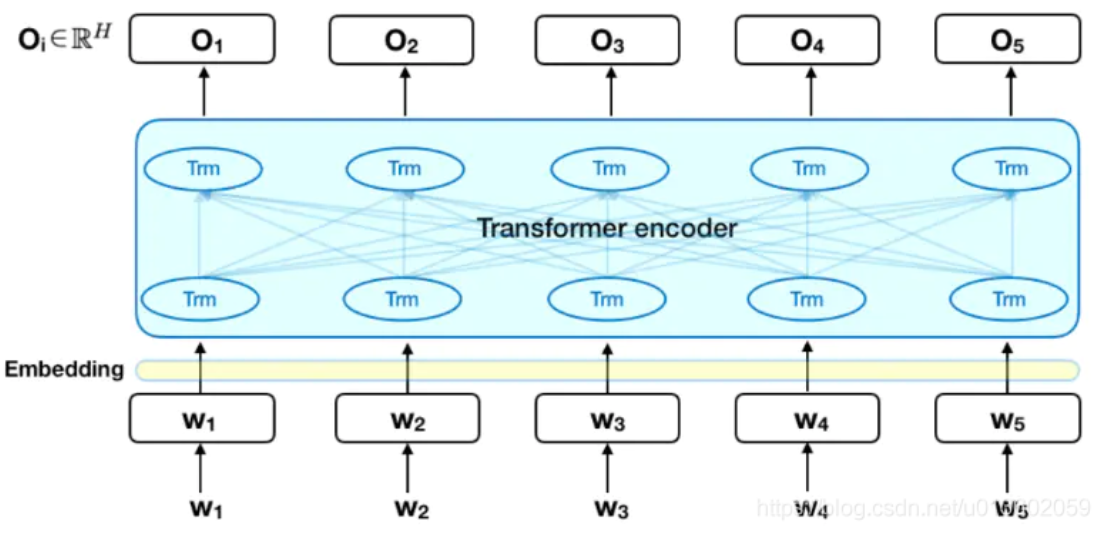
### 输入
`Bert`的输入如下:
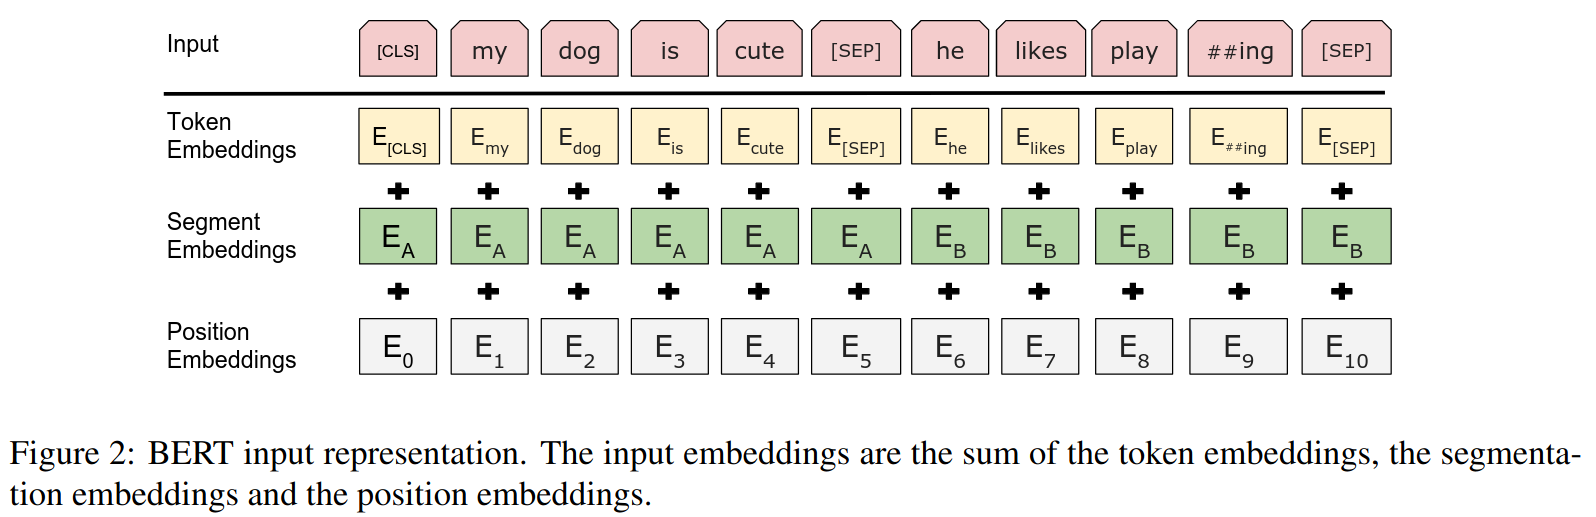
- 其中 `Token Embeddings` 使用预训练的 `word2vec` 模型进行词嵌入, 并且每一个 `sequence` 会以一个特殊的 `token [CLS]` 开始, 同时这也会作为分类任务的输出, 句子之间以 `special sperator token [SEP]` 进行分割
- `Segment Embedding`也可以用于分割句子, 但是主要用于区分句子对, `Embedding A` 和 `Embedding B` 分别表示左右句子
- `Position Embedding`是用于给词元`Token`定位的, 学习出来的 `embedding` 向量, 和 `Transformer` 不同, 这里的位置编码是学习得到的, `Transformer` 中是固定的
### 预训练Pre-training
`Bert`使用两种无监督任务来进行预训练, 两个任务同时训练, `Bert` 的损失函数就是两个任务的损失函数相加:
- `token-level` 级别的 `Masked LM`
- `sentence-level` 级别的 `Next Sentence Prediction`
#### 任务一: Masked LM
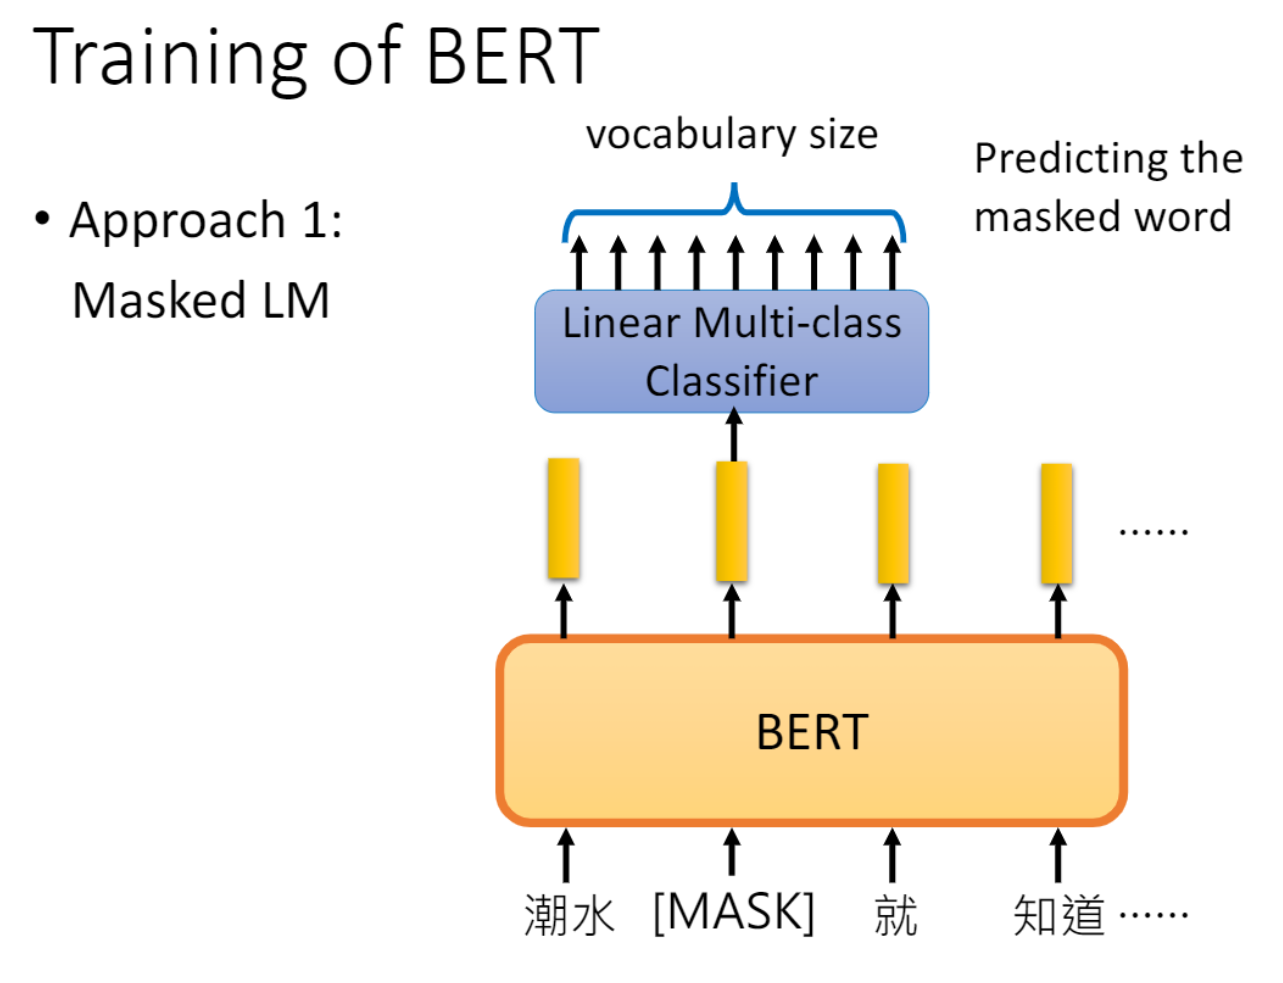
为了解决双向模型数据泄漏的问题, `Maksed LM`随机屏蔽一些 `token` 并且通过上下文来预测这些 `token` ; 同时在实验中, `Bert` 会随机屏蔽每一个序列中 15% 的 `token`, 并且使用 `[Mask] token` 来替代, 这就会导致 `[MASK token]` 不会出现在下游任务中, 为了和后续任务保持一致, 采样如下三种方式替代 `[MASK] token`, 比如 `my dog is hariy`:
- 80% 的 `[MASK] token` 继续保持 `[MASK]`
- 10% 的 `[MASK] token` 被随机的一个单词取代
- 10% 的 `[MASK] token` 会保持原单词不变(但是依然需要预测)
最终 `Masked ML`的损失函数只能由 `[MASK]` 的部分来计算, 在 `encoder` 的输出上面添加一个前馈神经网络, 并且转换为词汇的维度, 并且使用 `softmax` 计算概率(利用交叉熵损失)

### 任务二: Next Sentence Prediction
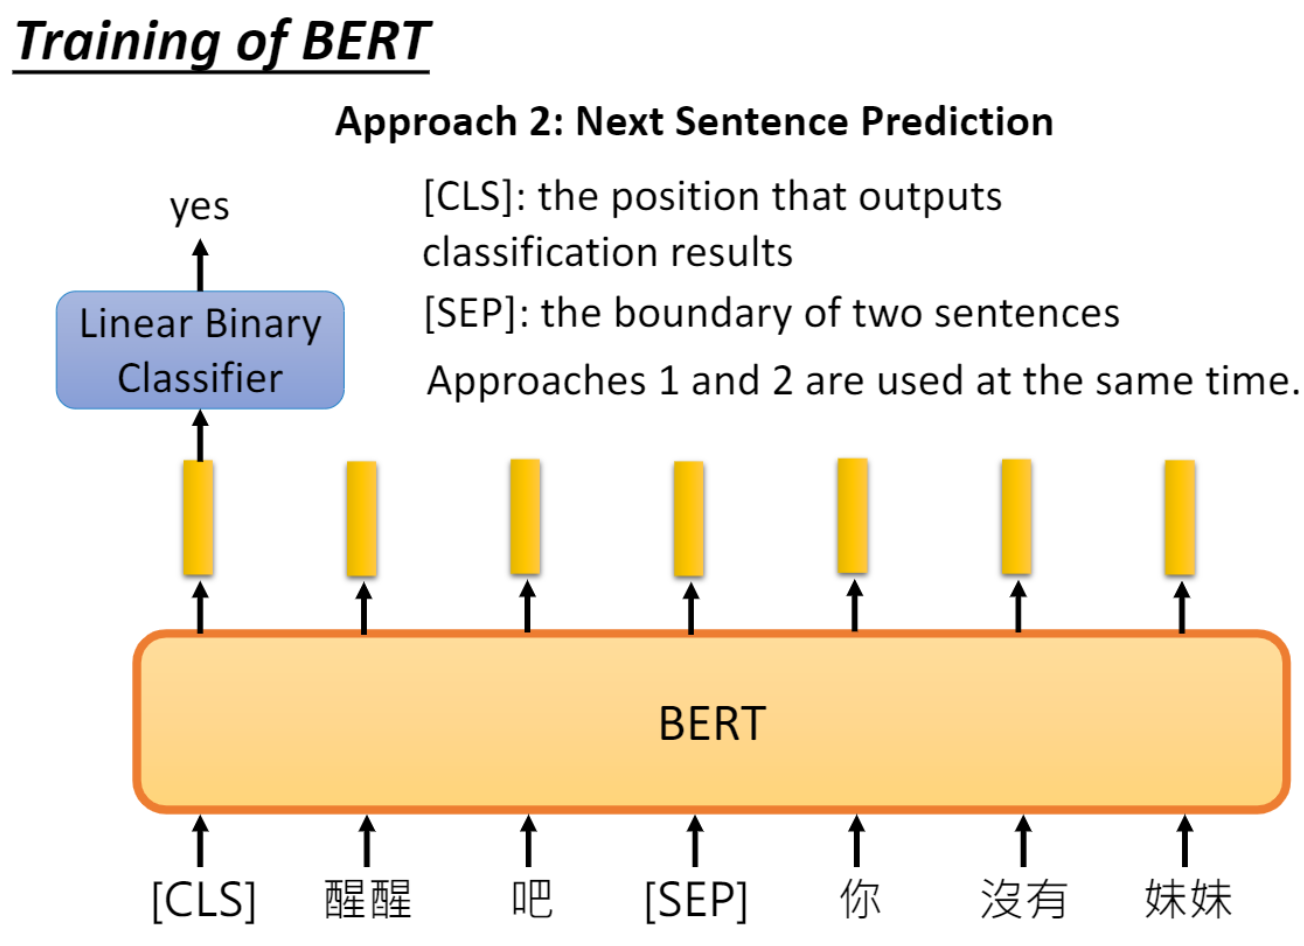
由于语言模型智能捕捉 `token-level` 级别的关系, 所以为了捕捉 `sentence-level` 级别的关系, 需要训练一个 `sentence-level`级的分类任务, 训练的输入是句子 `A` 和 `B`(`sentence-level`级负采样):
- `B` 有一半的概率是 `A` 的下一句, 为正例
- `B` 有一半的例子是随机取一个句子作为负例

这里注意负采样的思想(主要是考虑两面性, 也就是同时考虑正常情况以及随机情况)

通过 `classification token`连接 `Softmax` 输出 `B` 是不是 `A` 的下一句, 在训练 `Bert` 模型的时候, `Masked LM` 和 `Next Sentence Prediction` 是一起训练的, 目标就是最小化两种策略的组合损失函数

## 微调Fine-tuning
在 `Bert` 的预训练已经完成了 `token-level` 和 `sentence-level` 关系的学习, 所以 `Fine-tuning` 比较简单, 针对于不同的 `NLP` 下游任务, 只需要在 `Bert` 输出之后添加对应的模块(比如线性层, `CNN`, `CRF` 等), 并且把具体的输入和输出输入到 `Bert` 中, 并且端到端调整模型参数即可
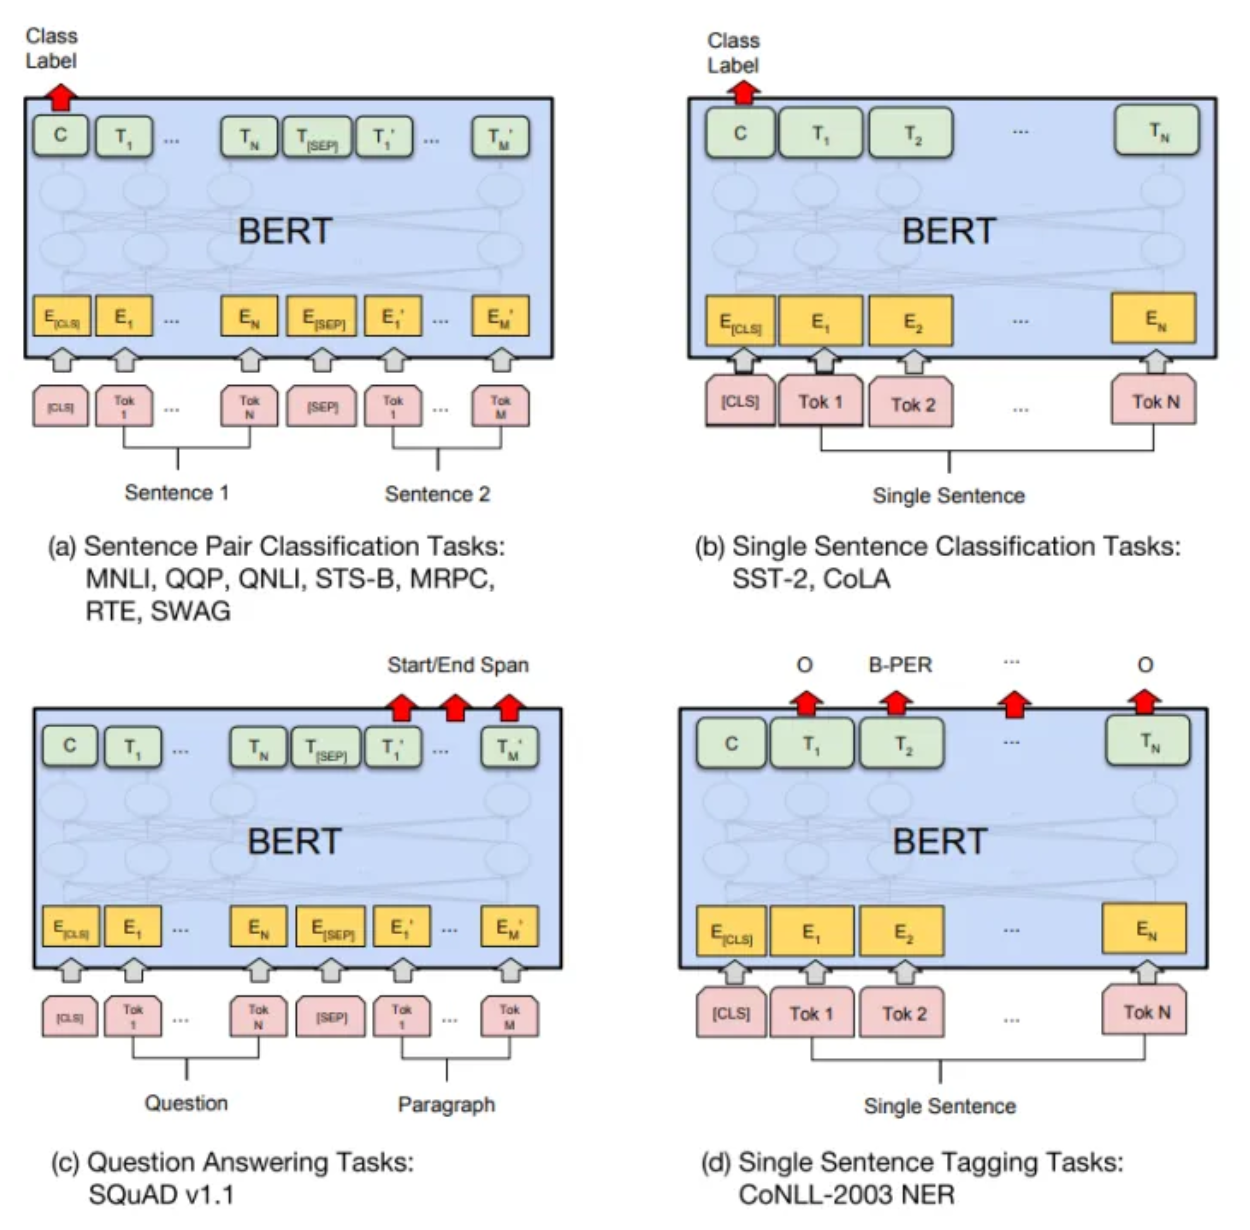
- 其中 `a, b` 是 `sentence-level` 级别的任务, 例如句子分类, 情感分析等, 输入句子或者句子对, 在 `[CLS]` 位接入 `Softmax` 输出 `Label`
- `c` 是 `token-level` 级别的任务, 例如 `Q-A` 问题, 输入问题和段落, 在 `Paragraph` 对应输出的 `hidden vector` 后接上两个 `Softmax` 层, 分别训练处 `Span` 的 `Start index` 和 `End index` 作为 `Question` 的答案
- `d` 也是 `token-level` 级别的任务, 比如命名实体识别问题, 接上 `Softmax` 就可以输出具体的分类

### 微调Bert解决下游NLP任务实例
**情感分析:**
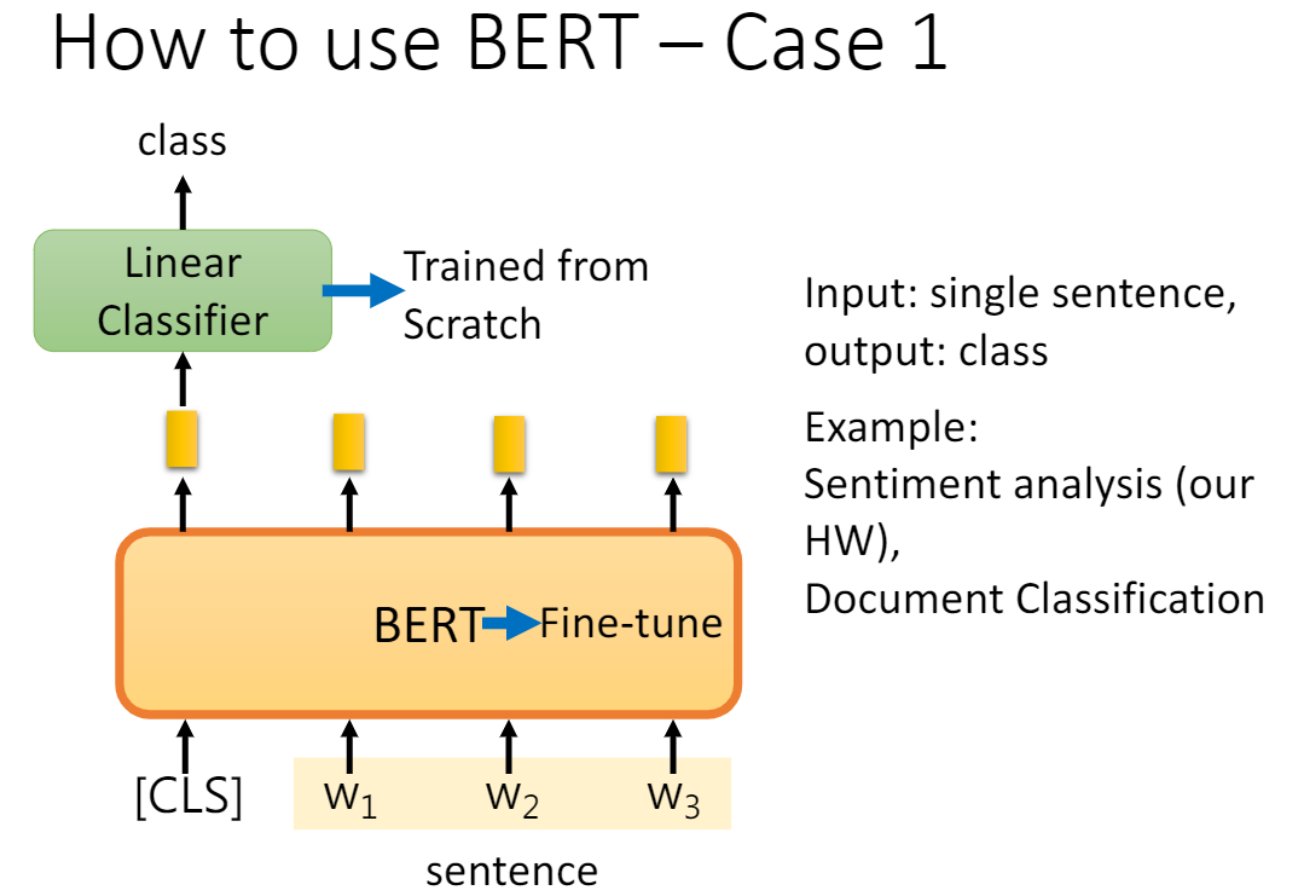
**命名实体识别:** 系统接受文本序列, 标记文本中的各种类型的实体, 可以使用 `Bert` 将每一个 `token` 的输出向量送到预测 `NER` 标签的分类层 (`token-level` 的一个多分类问题)
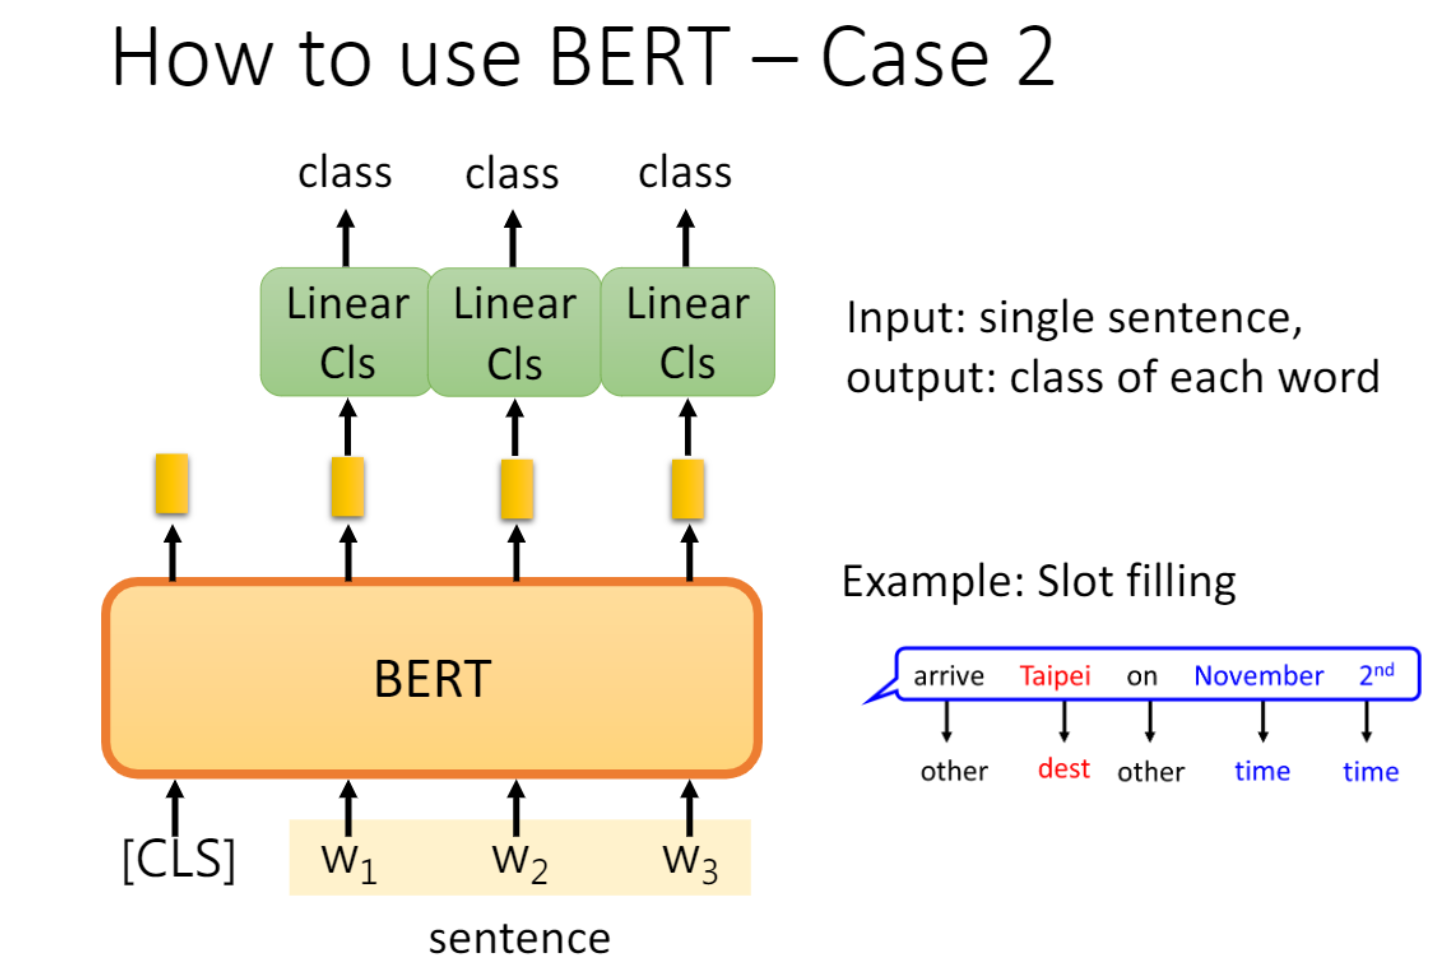
**句子关系蕴含(自然语言推断任务/相似匹配任务)**: 构造输入 `sentence1` 和 `sentence2`, 以及对应的 `label`:
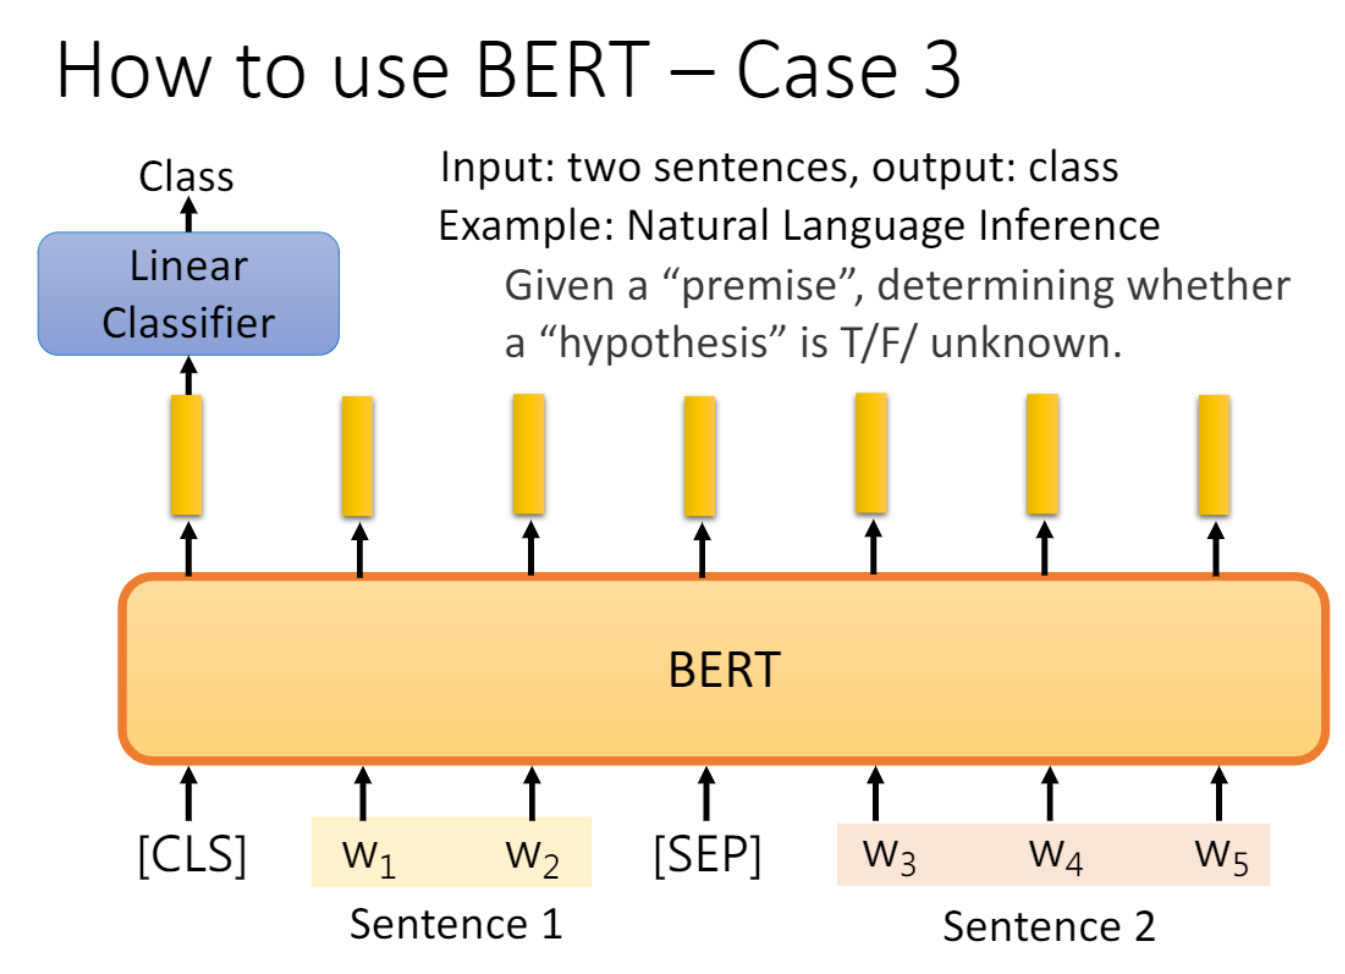
**QA任务**: 接受有关文本序列的 `question`, 并且需要在序列中标记 `answer`, 可以使用 `Bert` 学习两个标记 `answer` 开始和结尾的向量来训练 `Q & A` 模型
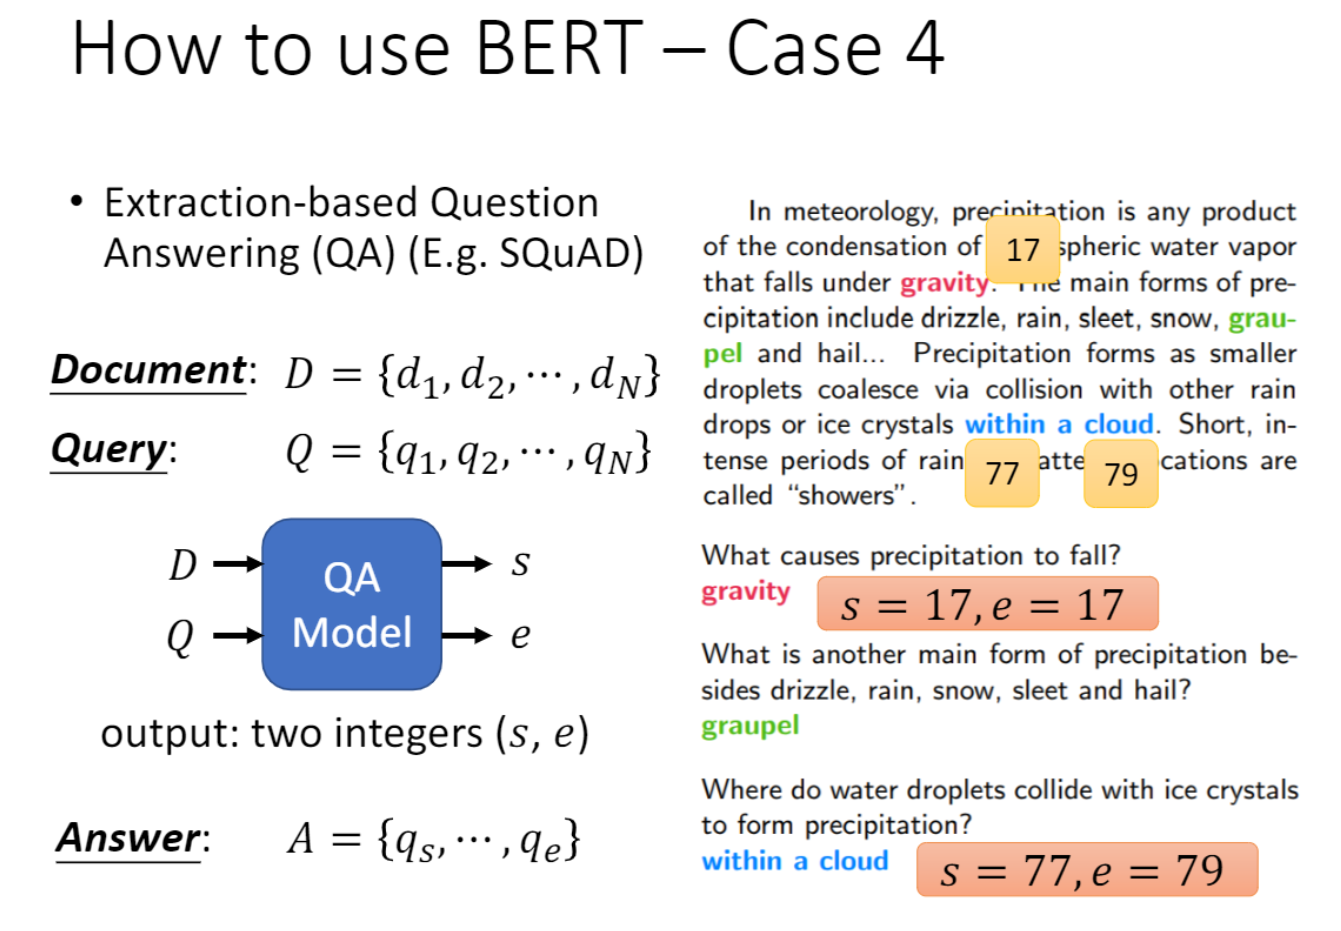

## 总结
`Bert`  采用 `Pre-traning` 和 `Fine-tuning` 两阶段训练任务:
1. 在 `Pre-traning` 阶段使用多层双向 `Transformer Encoder` 进行训练, 并且采样 `Masked LM` 和 `Next Sentence Prediction` 两种任务解决 `token-level` 和 `sentence-level` 的问题, 为下游任务提供一个通用的模型框架
2. 在 `Fine-tuning` 阶段针对于具体的 `NLP` 任务进行微调从而适应不同种类的任务需求, 并且通过端到端的训练更新参数从而得到最终的模型

`Bert` **优点:**
- `Bert` 的双层 `Transformer Encoder` 的 `Self-Attention` 结构可以更好建模上下文信息, 从而经过语料上训练之后, 可以获取到输入文本比较优质的语义表征
- `Bert` 的 `ML` 和 `NSP` 联合训练, 从而可以适配下游多认为

`Bert` **缺点:**
- `[Mask] token` 推理是不会出现, 因此训练时使用过多 `[MASK]` 会影响模型表现
- 每一个 `batch` 只有 15% 的 `token` 被预测, 所以收敛速度比较慢
- `Bert` 上下文长度固定为 `512`, 输入过长需要阶段(长文本不友好)